In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [24]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [25]:
NUM_CLASSES = 5

# Dataset reading

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [30]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                860       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [32]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [33]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/35 [..............................] - ETA: 8s - loss: 2.1533 - accuracy: 0.1797

InvalidArgumentError:  Received a label value of 5 which is outside the valid range of [0, 5).  Label values: 2 0 1 1 0 2 1 3 0 1 1 1 0 0 4 4 0 3 2 2 2 2 3 1 1 2 4 0 2 4 2 0 2 0 4 4 0 2 4 0 4 0 2 4 1 3 3 1 0 4 2 5 2 2 4 3 0 0 4 2 2 0 0 2 1 1 4 1 3 2 1 1 4 4 1 3 4 0 2 4 4 0 0 0 1 1 0 1 2 1 1 0 2 2 0 2 0 3 2 0 1 2 4 0 0 4 1 2 1 0 4 3 3 1 0 0 1 0 4 3 2 1 1 1 1 0 4 2
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-33-97b42b06cced>:1) ]] [Op:__inference_test_function_23228]

Function call stack:
test_function


In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

In [34]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [35]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.6898559e-02 1.8084610e-01 8.0220956e-01 2.7795997e-05 1.8066943e-05]
2


# Confusion matrix

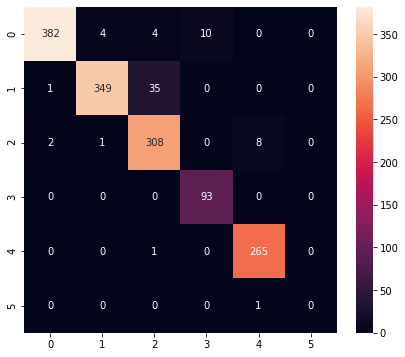

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       400
           1       0.99      0.91      0.94       385
           2       0.89      0.97      0.92       319
           3       0.90      1.00      0.95        93
           4       0.97      1.00      0.98       266
           5       0.00      0.00      0.00         1

    accuracy                           0.95      1464
   macro avg       0.79      0.80      0.80      1464
weighted avg       0.96      0.95      0.95      1464



C:\Users\offic\anaconda3\envs\py39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\offic\anaconda3\envs\py39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\offic\anaconda3\envs\py39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [37]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [38]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\offic\AppData\Local\Temp\tmp3wp40bof\assets


INFO:tensorflow:Assets written to: C:\Users\offic\AppData\Local\Temp\tmp3wp40bof\assets


6400

# Inference test

In [39]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [40]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [41]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [42]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [43]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.6898548e-02 1.8084598e-01 8.0220962e-01 2.7795972e-05 1.8066961e-05]
2
